HPCA(WT) vs. HPCA(N75K)
=======================

In [1]:
import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io

from scipy import ndimage
from scipy import signal
from scipy import stats


from domb.reg_type.wf_x2_m2 import WF_2x_2m as WF
from domb.fret.e_app import Eapp
from domb.red_green.wt_vs_mut import WTvsMut as WvM
from domb.utils import plot
from domb.utils.plot import CMaps
from domb.utils import masking

23_06_06_04 - bad FRET (>30%)

23_06_28_05 - bad soma

23_06_28_04 - bad WT

23_06_28_02 - good?

23_06_23_11 - good?

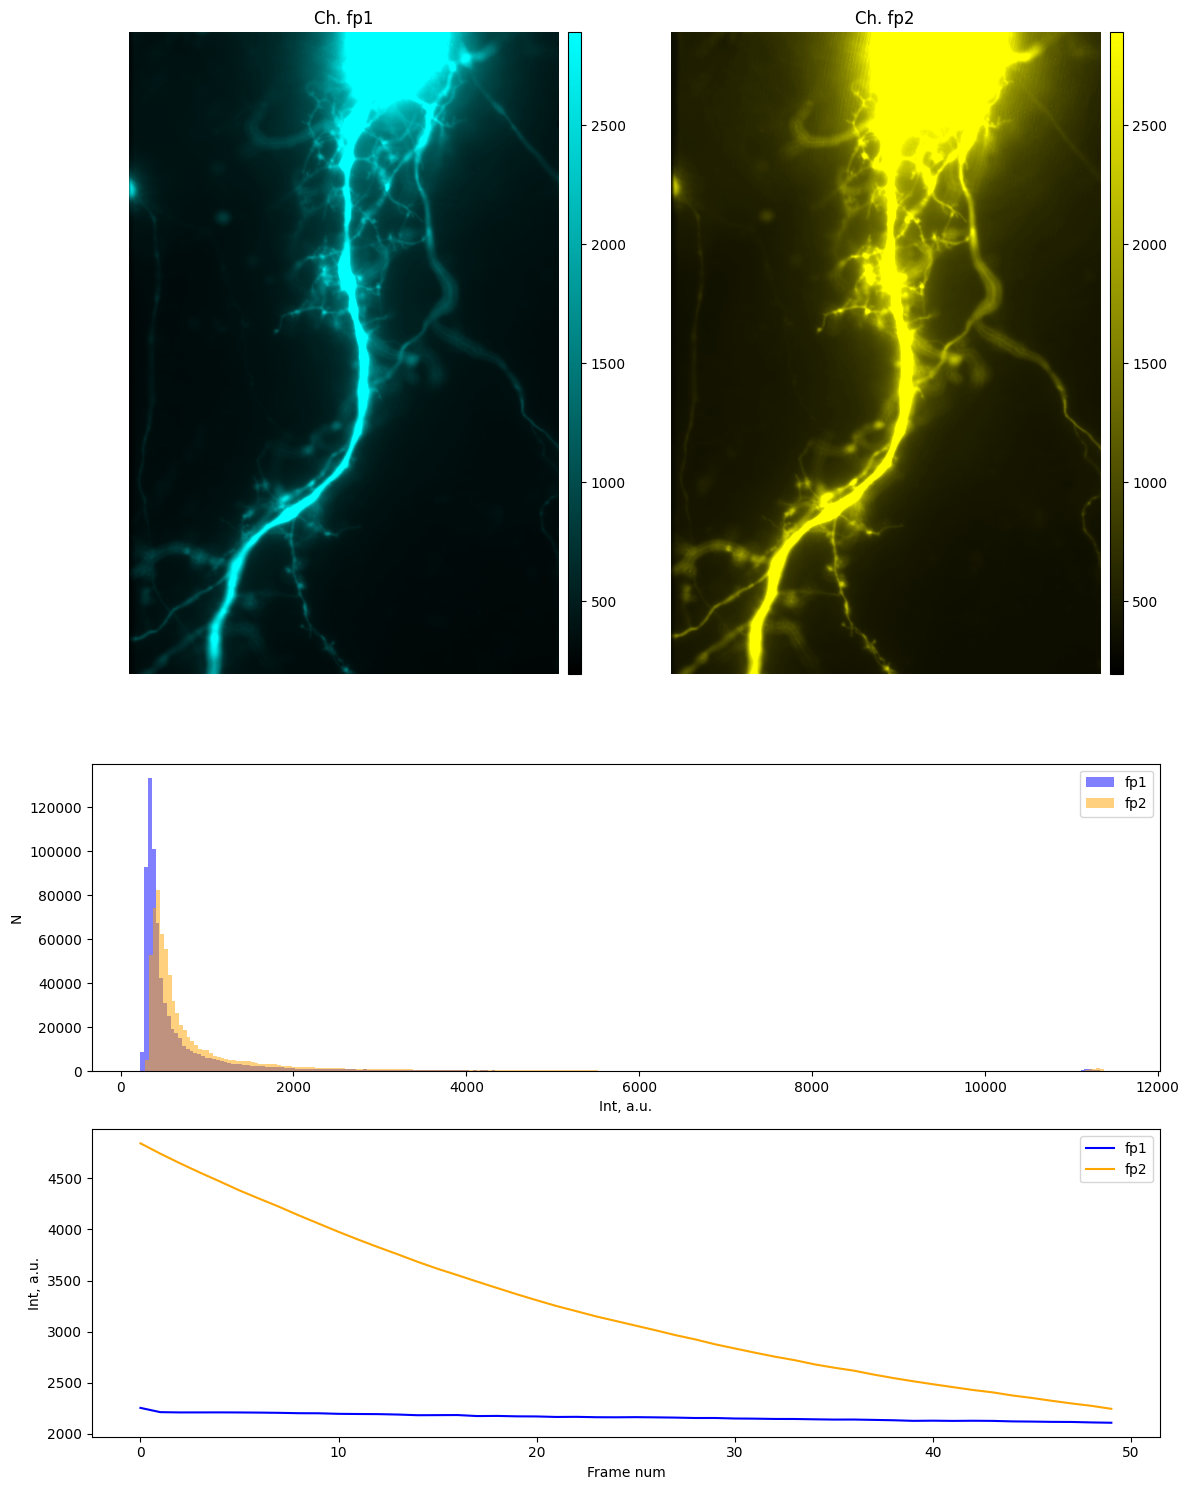

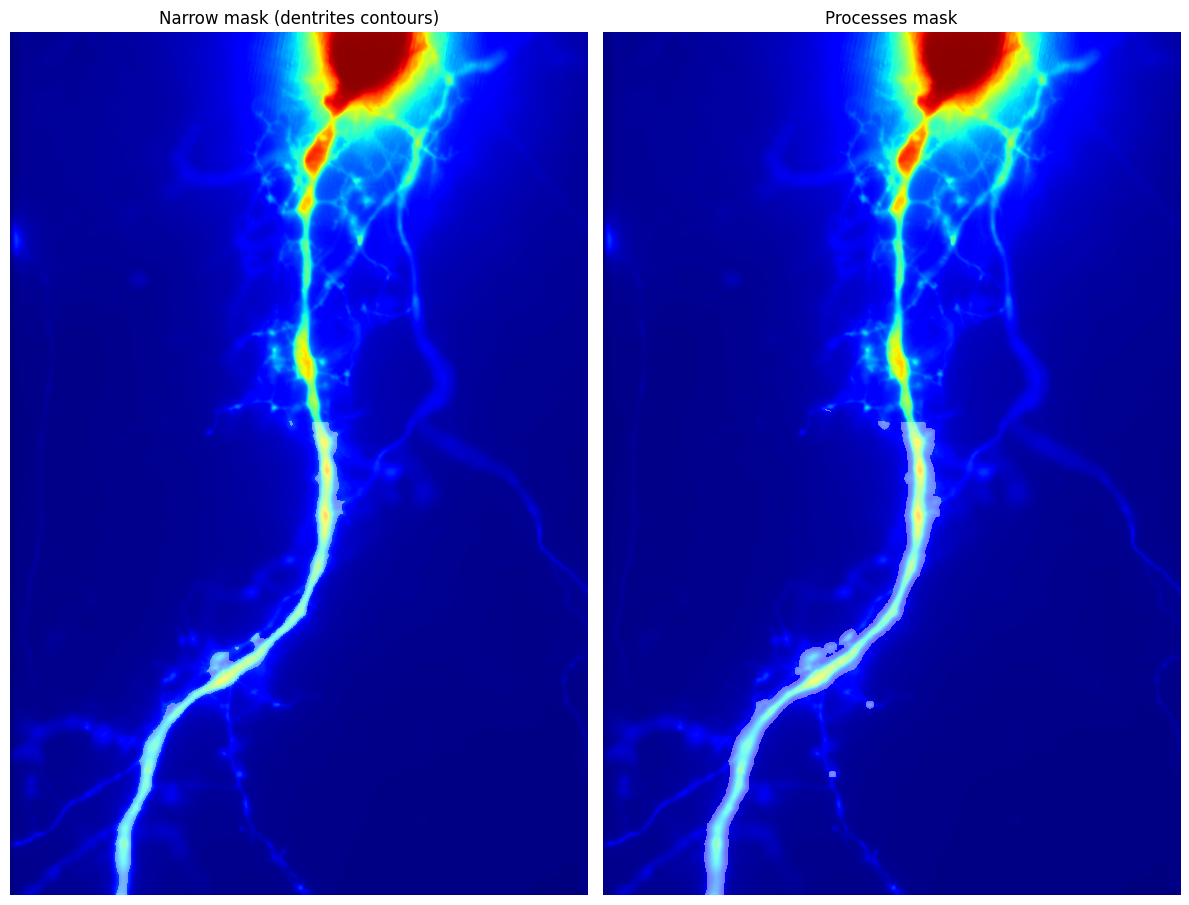

In [43]:
reg_path = 'data/wt_vs_mut/23_06_28_06.tif'
reg_name = reg_path.split('/')[-1]
reg_name = reg_name.split('.')[0]


# fp1 - CFP, fp2 - YFP
reg = WF(img_path=reg_path, img_name=reg_name, ch_order={'fp1':0,'fp2':3}, wf_sigma=.75,
         soma_mask=True, soma_th=.7, soma_ext=300, proc_sigma=1)  # processes masking parameters

reg.ch_pic()
reg.processes_mask_pic()

## RG

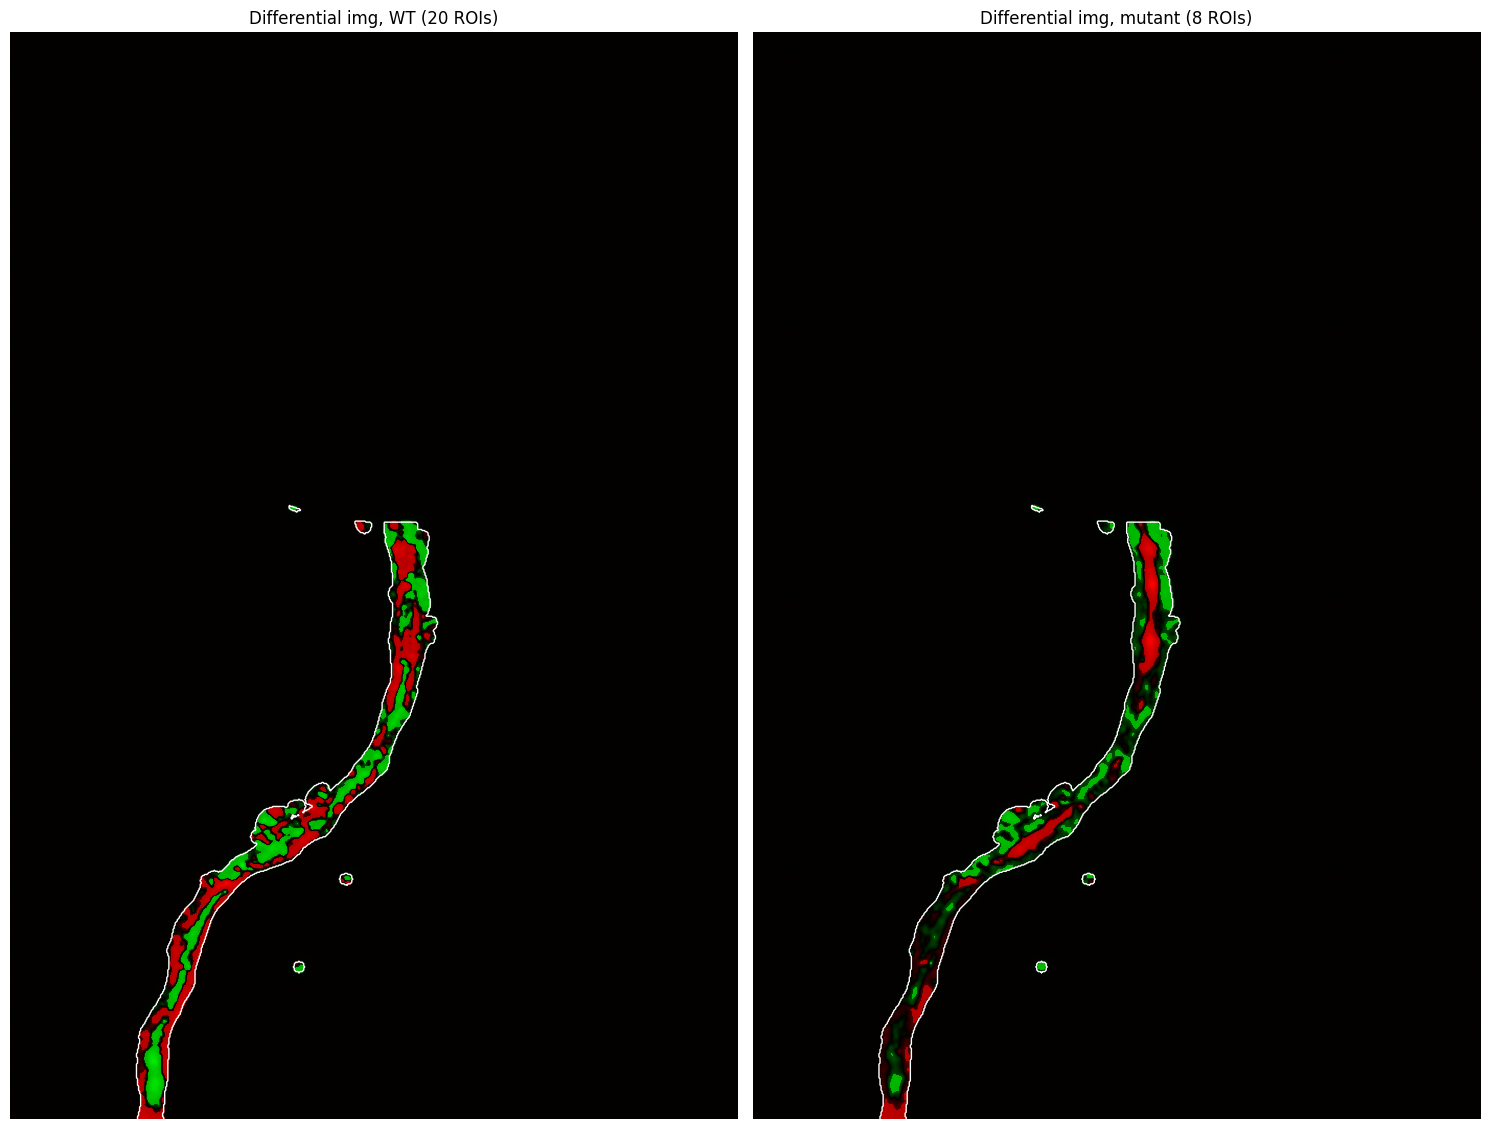

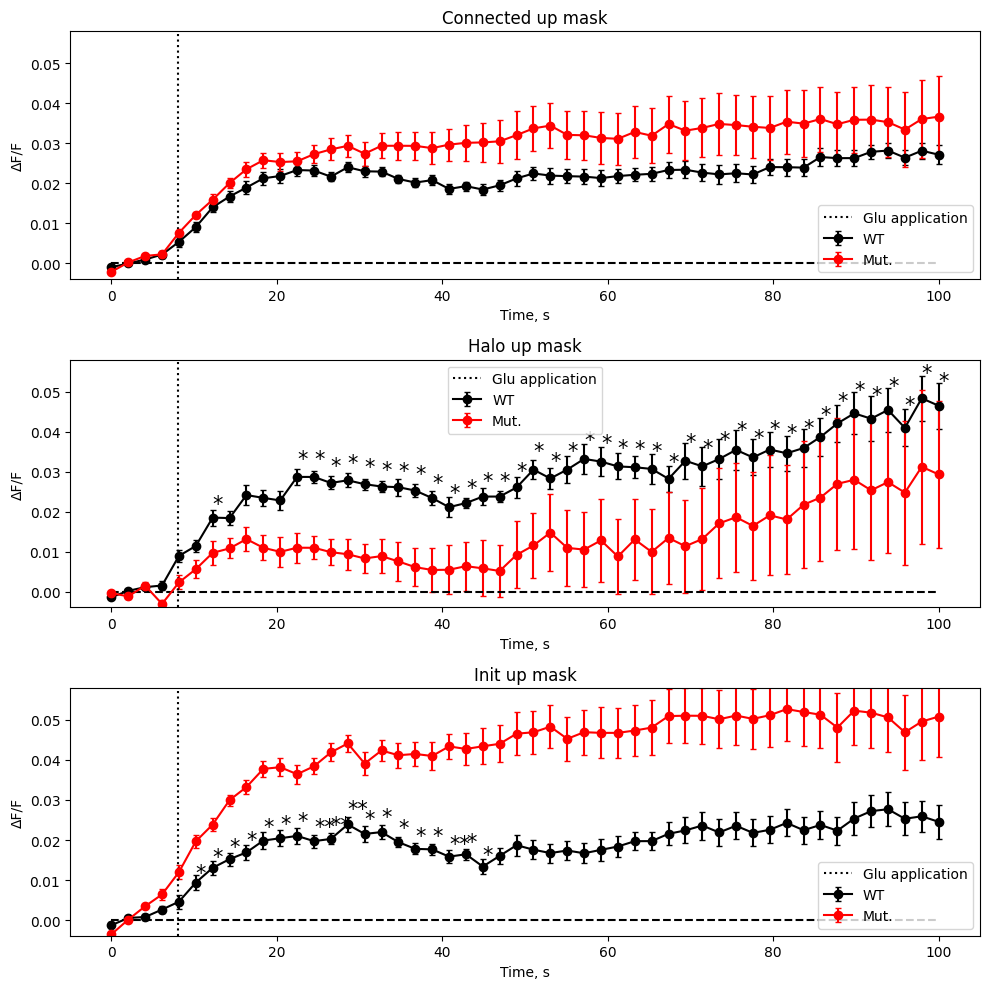

In [44]:
reg_RG = WvM(wt_img=reg.corr_fp1_img,
             mut_img=reg.corr_fp2_img,
             narrow_proc_mask=reg.narrow_proc_mask,
             proc_mask=reg.proc_mask,
             sd_tolerance=1, base_frames=5, stim_start=6, stim_win=10)  # up mask calc parameters

reg_RG.diff_img_pic()
reg_RG.df_mean_prof_pic()

/home/wisstock/anaconda3/envs/domb/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/wisstock/anaconda3/envs/domb/lib/python3.10/site-packages/numpy/core/_methods.py:195: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/home/wisstock/anaconda3/envs/domb/lib/python3.10/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wisstock/anaconda3/envs/domb/lib/python3.10/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


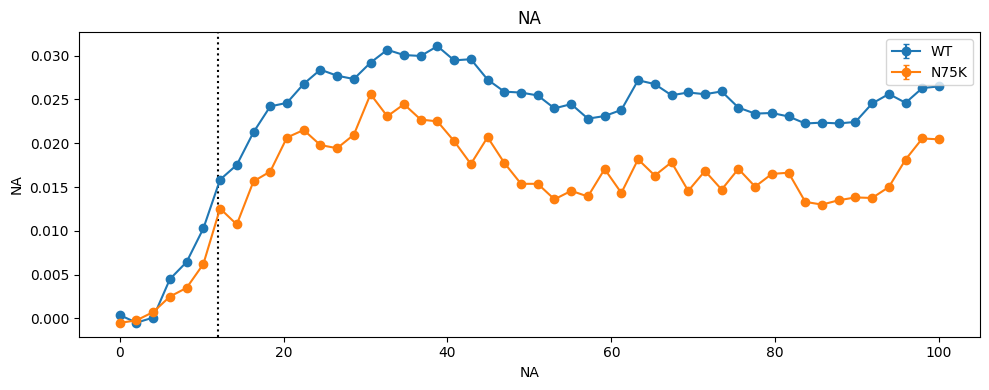

In [36]:
wt_wtup_df_arr,_ = masking.label_prof_arr(input_label=reg_RG.wt_up_mask,
                                          input_img_series=reg_RG.wt_img)
mut_wtup_df_arr,_ = masking.label_prof_arr(input_label=reg_RG.wt_up_mask,
                                           input_img_series=reg_RG.mut_img)

plot.stat_line_plot(arr_list=[wt_wtup_df_arr, mut_wtup_df_arr],
                    lab_list=['WT', 'N75K'],
                    stat_method='ci',
                    figsize=(10,4))

/home/wisstock/bio/scripts/DoMB_tools/src/domb/utils/plot.py:117: RuntimeWarning: invalid value encountered in divide
  b_norm_img = (b_img - np.min(b_img)) / (np.max(b_img) - np.min(b_img)).astype(np.uint8)
/home/wisstock/anaconda3/envs/domb/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


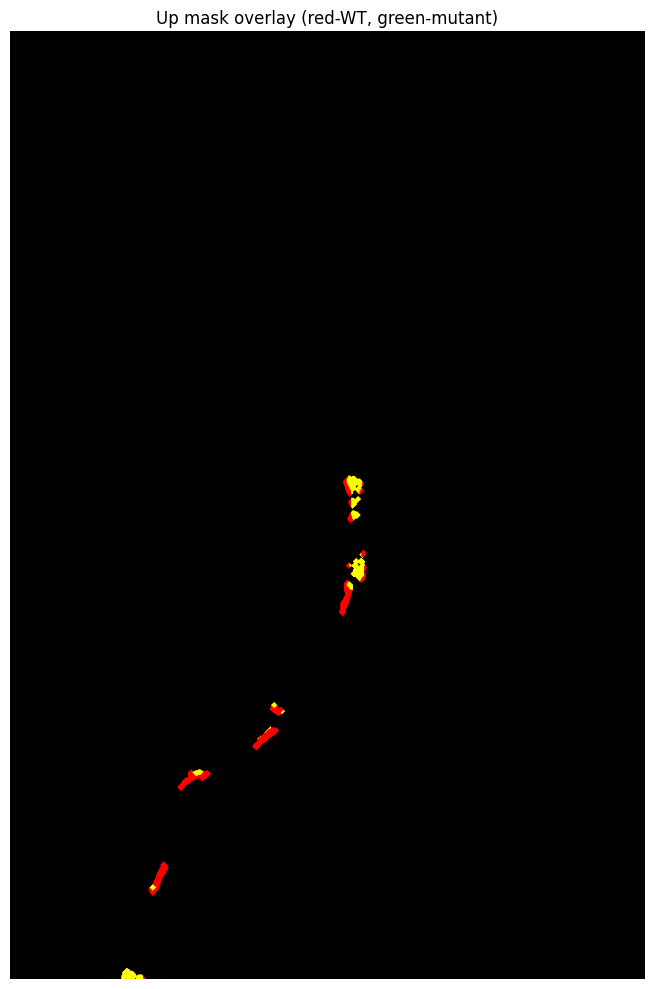

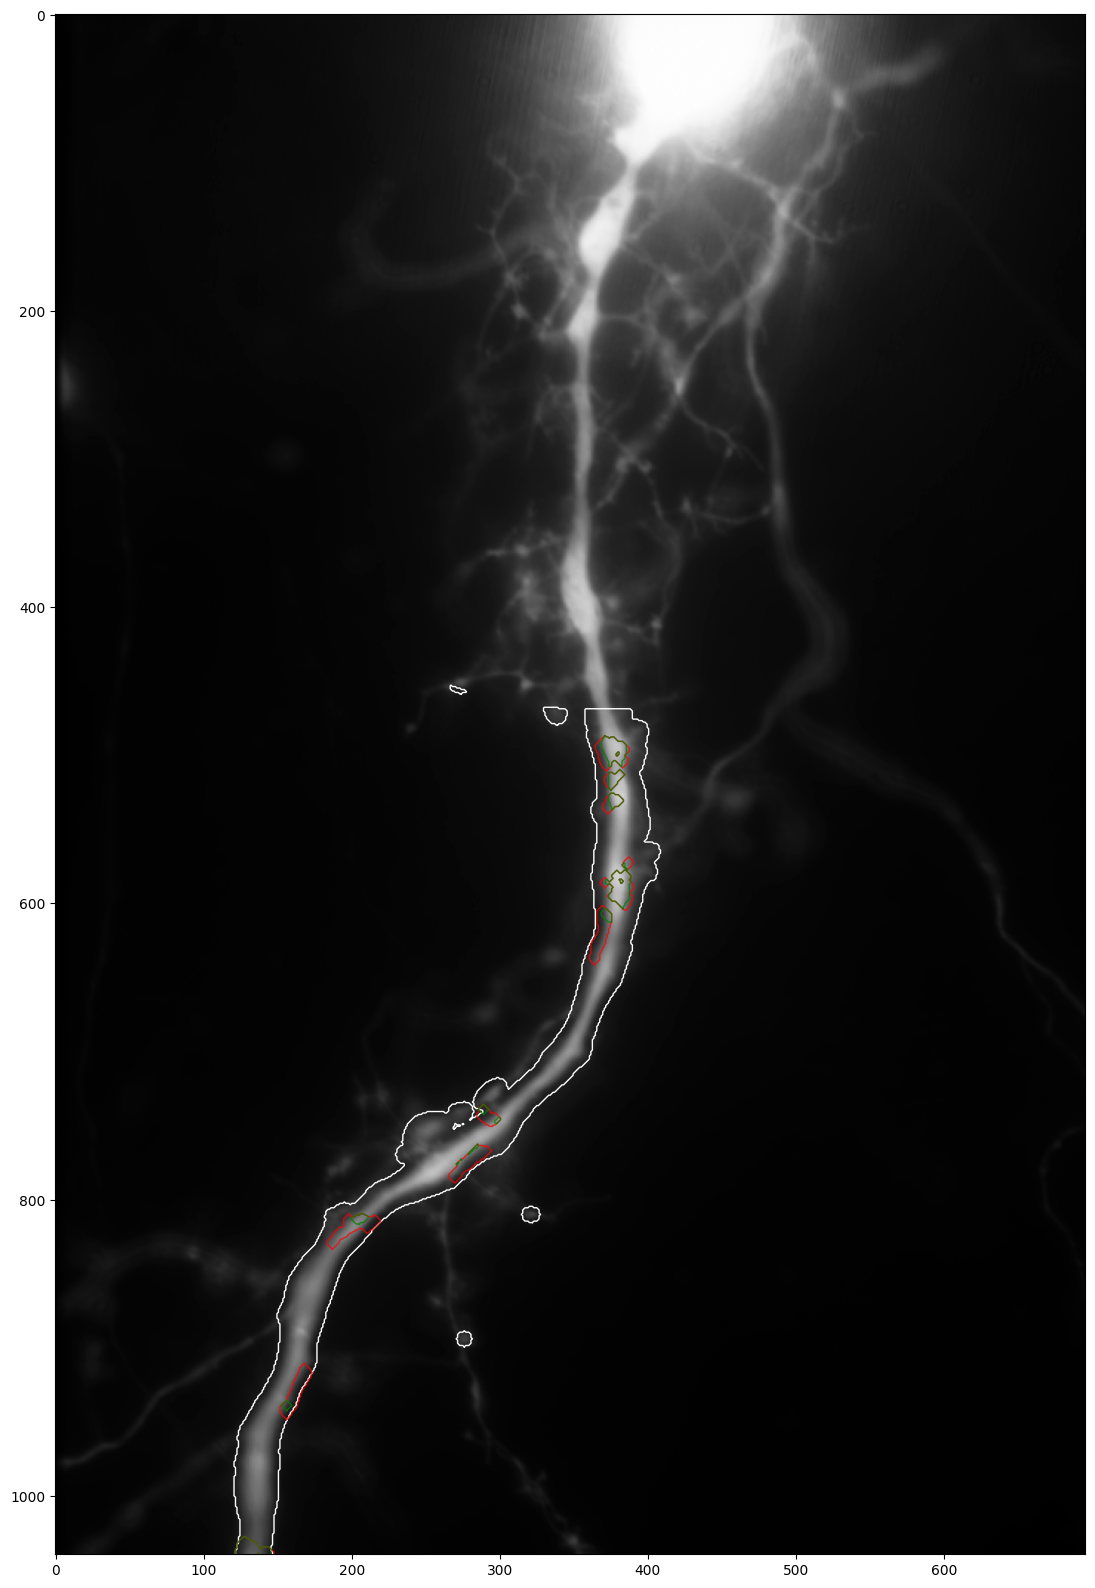

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(plot.toRGB(reg_RG.connected_up_mask, reg_RG.init_up_mask, np.zeros_like(reg_RG.wt_up_mask)))
plt.axis('off')
plt.title('Up mask overlay (red-WT, green-mutant)')
plt.tight_layout()
plt.show()


cell_contour = measure.find_contours(reg.proc_mask, level=0.5)
conn_contour = measure.find_contours(reg_RG.connected_up_mask, level=0.5)
init_contour = measure.find_contours(reg_RG.init_up_mask, level=0.5)

plt.figure(figsize=(20,20))
plt.imshow(reg.fp2_mean_img_raw *-1, cmap='Greys')
for ce_c in cell_contour:
    plt.plot(ce_c[:, 1], ce_c[:, 0], linewidth=1, color='w')
for co_c in conn_contour:
    plt.plot(co_c[:, 1], co_c[:, 0], linewidth=1, color='r', alpha=.75)
for in_c in init_contour:
    plt.plot(in_c[:, 1], in_c[:, 0], linewidth=1, color='g', alpha=.75)
plt.show()

## FRET

In [47]:
a=0.1489
b=0.1324
c=0.2481
d=0.8525
abcd = [a, b, c, d]

G = 6.117

reg_FRET = Eapp(dd_img=reg.ch0_img,
                da_img=reg.ch1_img,
                ad_img=reg.ch2_img,
                aa_img=reg.ch3_img,
                abcd_list=abcd, G_val=G,
                mask=reg.narrow_proc_mask, corr_by_mask=True)  # parameters for E_corr_calc

_,conn_fret = masking.label_prof_arr(input_label=reg_RG.connected_up_label,
                                   input_img_series=reg_FRET.Ecorr_img)
_,halo_fret = masking.label_prof_arr(input_label=reg_RG.halo_up_label, 
                                   input_img_series=reg_FRET.Ecorr_img)
_,init_fret = masking.label_prof_arr(input_label=reg_RG.init_up_label,
                                   input_img_series=reg_FRET.Ecorr_img)

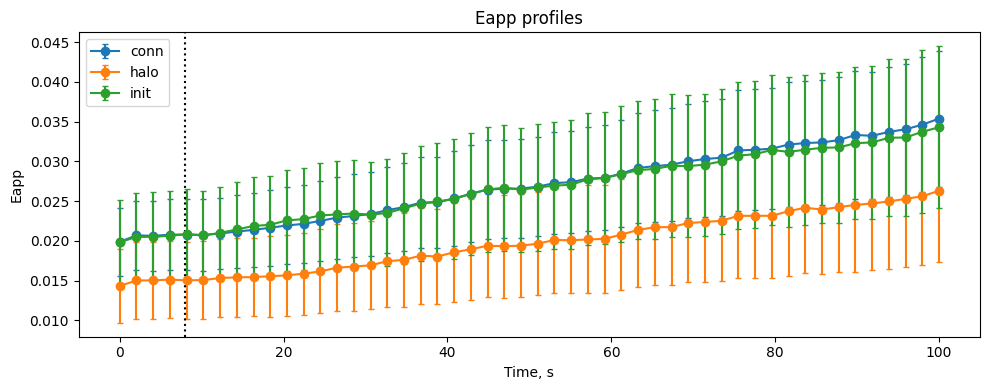

In [48]:
plot.stat_line_plot(arr_list=[conn_fret,
                              halo_fret,
                              init_fret],
                    lab_list=['conn', 'halo', 'init'],
                    stat_method='ci', stim_t=8,
                    figsize=(10,4), x_lab='Time, s', y_lab='Eapp', plot_title='Eapp profiles')

### FRET masking

In [ ]:
max_fret = reg_FRET.Ecorr_img[-1]

fret_mask = max_fret > filters.threshold_otsu(ma.masked_where(~reg.proc_mask, max_fret).compressed())
# fret_mask = max_fret > filters.threshold_otsu(max_fret)
fret_mask[~reg.proc_mask] = 0
fret_mask = morphology.opening(fret_mask, footprint=morphology.disk(3))

plt.imshow(fret_mask)
plt.show()

_,fret_fret = masking.label_prof_arr(input_label=measure.label(fret_mask),
                                   input_img_series=reg_FRET.Ecorr_img)

plot.stat_line_plot(arr_list=[fret_fret],
                    lab_list=['FRET mask'],
                    stat_method='se',
                    figsize=(10,4))

## dF vs. FRET

In [ ]:
time_line = np.linspace(0, wt_mean.shape[0]*2, \
                            num=wt_mean.shape[0])

df_profiles = pd.DataFrame(columns=['ID', 'ROI', 'mask', 'time', 'type', 'int'])

delta = lambda f, f_0: (f - f_0)/f_0
vdelta = np.vectorize(delta)

# for roi_num in np.unique(reg_RG.connected_up_label)[1:]:
#     roi_mask = reg_RG.connected_up_label == roi_num
#     wt_prof = np.mean(reg.corr_fp1_img, axis=(1,2), where=roi_mask)
#     wt_prof = vdelta(np.mean(wt_prof[:5]), wt_prof)
#     mut_prof = np.mean(reg.corr_fp2_img, axis=(1,2), where=roi_mask)
#     mut_prof = vdelta(np.mean(mut_prof[:5]), mut_prof)
#     fret_prof = np.mean(reg_FRET.Ecorr_img, axis=(1,2), where=roi_mask)
#     df = pd.DataFrame({'ID':np.full(wt_prof.shape[0]*3, reg.img_name),
#                             'ROI':np.full(wt_prof.shape[0]*3, roi_num),
#                             'mask':np.full(wt_prof.shape[0]*3, 'conn'),
#                             'time':np.concatenate((time_line, time_line, time_line)),
#                             'type':np.concatenate((np.full(wt_prof.shape[0], 'WT'),
#                                                    np.full(wt_prof.shape[0], 'N75K'),
#                                                    np.full(wt_prof.shape[0], 'FRET'))),
#                             'int':np.concatenate((wt_prof, mut_prof, fret_prof))})
#     df_profiles = pd.concat([df_profiles, df], ignore_index=True)

# for roi_num in np.unique(reg_RG.init_up_label)[1:]:
#     roi_mask = reg_RG.connected_up_label == roi_num
#     wt_prof = np.mean(reg.corr_fp1_img, axis=(1,2), where=roi_mask)
#     wt_prof = vdelta(np.mean(wt_prof[:5]), wt_prof)
#     mut_prof = np.mean(reg.corr_fp2_img, axis=(1,2), where=roi_mask)
#     mut_prof = vdelta(np.mean(mut_prof[:5]), mut_prof)
#     fret_prof = np.mean(reg_FRET.Ecorr_img, axis=(1,2), where=roi_mask)
#     df = pd.DataFrame({'ID':np.full(wt_prof.shape[0]*3, reg.img_name),
#                             'ROI':np.full(wt_prof.shape[0]*3, roi_num),
#                             'mask':np.full(wt_prof.shape[0]*3, 'init'),
#                             'time':np.concatenate((time_line, time_line, time_line)),
#                             'type':np.concatenate((np.full(wt_prof.shape[0], 'WT'),
#                                                    np.full(wt_prof.shape[0], 'N75K'),
#                                                    np.full(wt_prof.shape[0], 'FRET'))),
#                             'int':np.concatenate((wt_prof, mut_prof, fret_prof))})
#     df_profiles = pd.concat([df_profiles, df], ignore_index=True)

for roi_num in np.unique(reg_RG.halo_up_label)[1:]:
    roi_mask = reg_RG.connected_up_label == roi_num
    wt_prof = np.mean(reg.corr_fp1_img, axis=(1,2), where=roi_mask)
    wt_prof = vdelta(wt_prof, np.mean(mut_prof[:5]))
    mut_prof = np.mean(reg.corr_fp2_img, axis=(1,2), where=roi_mask)
    mut_prof = vdelta(mut_prof, np.mean(mut_prof[:5]))
    fret_prof = np.mean(reg_FRET.Ecorr_img, axis=(1,2), where=roi_mask)
    df = pd.DataFrame({'ID':np.full(wt_prof.shape[0]*3, reg.img_name),
                            'ROI':np.full(wt_prof.shape[0]*3, roi_num),
                            'mask':np.full(wt_prof.shape[0]*3, 'halo'),
                            'time':np.concatenate((time_line, time_line, time_line)),
                            'type':np.concatenate((np.full(wt_prof.shape[0], 'WT'),
                                                   np.full(wt_prof.shape[0], 'N75K'),
                                                   np.full(wt_prof.shape[0], 'FRET'))),
                            'int':np.concatenate((wt_prof, mut_prof, fret_prof))})
    df_profiles = pd.concat([df_profiles, df], ignore_index=True)

df_profiles

In [ ]:
fig = px.line(df_profiles, x='time', y='int', color='mask',
              line_dash='type', animation_frame='ROI')
fig.show()

In [ ]:
arr_se_stat = lambda x: (np.mean(x, axis=0), \
                         np.std(x, axis=0)/np.sqrt(x.shape[1]))

wt_mean, wt_var = arr_se_stat(reg_RG.wt_conn_df_arr) 
mut_mean, mut_var = arr_se_stat(reg_RG.mut_conn_df_arr)

fret_mean, fret_var = arr_se_stat(conn_fret)


time_line = np.linspace(0, wt_mean.shape[0]*2, \
                            num=wt_mean.shape[0])

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.errorbar(time_line, wt_mean,
             yerr = wt_var,
             fmt ='-o', color='k', capsize=4, label='WT')
ax1.errorbar(time_line, mut_mean,
             yerr = mut_var,
             fmt ='-o', color='r', capsize=4, label='N75K')
ax1.set_xlabel('Time, s')
ax1.set_ylabel('ΔF/F', color='r')
ax1.tick_params(axis ='y', labelcolor='r')
ax1.hlines(y=0, xmin=0, xmax=time_line.max(), linestyles='--', color='k')
ax1.axvline(x=10, color='k', linestyle=':', label='Glu application')

plt.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.errorbar(time_line, fret_mean*100,
             yerr = fret_var*100,
             fmt ='-o', color='b', capsize=4, label='FRET')
ax2.set_ylim([0,20])
ax2.set_ylabel('E app, %', color='b')
ax2.tick_params(axis ='y', labelcolor='b')

plt.legend(loc='lower left')
plt.tight_layout()
plt.title('Connected')
plt.show()

## OLD STAT

#### Max amp stat

In [ ]:
wt_amp_prof = cfp_dist_prof_arr_con_mask
mut_amp_prof = yfp_dist_prof_arr_con_mask

max_frame = 10

wt_max_amp = wt_amp_prof[:, max_frame]
mut_max_amp = mut_amp_prof[:, max_frame]

print(len(wt_max_amp), len(mut_max_amp))

amp_u_test = stats.mannwhitneyu(wt_max_amp, mut_max_amp)
print(f"U-test p-val={round(amp_u_test[1], 5)}")


wt_amp_df = pd.DataFrame({'FP':np.full(len(wt_max_amp), 'WT'),
                           'amp':wt_max_amp})
mut_amp_df = pd.DataFrame({'FP':np.full(len(mut_max_amp), 'N75K'),
                           'amp':mut_max_amp})
amp_df = pd.concat([wt_amp_df, mut_amp_df], ignore_index=True)


fig = px.box(amp_df, x='FP', y='amp', color='FP', points='all',
             title=f'<b>U-test p={round(amp_u_test[1], 3)}</b>',
             labels={"amp": "<b>ΔF/F</b>", "FP": ""},
             color_discrete_sequence=['#000000', '#ff0000'])
fig.update_layout(height=600, width=300, showlegend=False,
                  margin={'l':0, 'r':10, 't':50, 'b':0},
                  font={"size":15, "color":"#000000"},  # "family":"Nunito", 
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.update_yaxes(ticks='inside',
                 showline=False,
                 gridcolor='grey')
fig.show()

#### Area stat

In [ ]:
def area_calc(input_labels):
    input_props = measure.regionprops(input_labels)
    output_areas = []
    for reg_prop in input_props:
        output_areas.append(reg_prop.area)

    return output_areas


wt_up_areas = area_calc(connected_up_label)
mut_up_areas = area_calc(mutant_up_label)

print(len(wt_up_areas), len(mut_up_areas))

area_u_test = stats.mannwhitneyu(wt_up_areas, mut_up_areas)
print(f"U-test p-val={round(area_u_test[1], 5)}")


wt_area_df = pd.DataFrame({'FP':np.full(len(wt_up_areas), 'WT'),
                           'area':wt_up_areas})
mut_area_df = pd.DataFrame({'FP':np.full(len(mut_up_areas), 'N75K'),
                           'area':mut_up_areas})
area_df = pd.concat([wt_area_df, mut_area_df], ignore_index=True)


fig = px.box(area_df, x='FP', y='area', color='FP', points='all',
             title=f'<b>U-test p={round(area_u_test[1], 3)}</b>',
             labels={"area": "<b>ROIs area, px</b>", "FP": ""},
             color_discrete_sequence=['#000000', '#ff0000'])
fig.update_layout(height=600, width=300, showlegend=False,
                  margin={'l':0, 'r':10, 't':50, 'b':0},
                  font={"size":15, "color":"#000000"},  # "family":"Nunito", 
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.update_yaxes(ticks='inside',
                 showline=False,
                 gridcolor='grey')
fig.show()